# Examples of usage

Spatial graphs are used across `momepy`. This notebook will illustrate its use on three examples.

In [1]:
import momepy
import osmnx as ox
from libpysal import graph

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer.

In [2]:
gdf = ox.features_from_place("Kahla, Germany", tags={"building": True})
buildings = ox.projection.project_gdf(gdf).reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


## First order contiguity

### Distance to neighbours

To calculate the mean distance to neighbouring buildings, we need queen contiguity weights of the first order capturing the relationship between immediate neighbours. Relationship between buildings is here represented by relationships between their tessellation cells.

In [3]:
contiguity = graph.Graph.build_contiguity(tessellation)
contiguity

<Graph of 3014 nodes and 17534 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

In [4]:
buildings["neighbour_dist"] = momepy.neighbor_distance(buildings, contiguity)

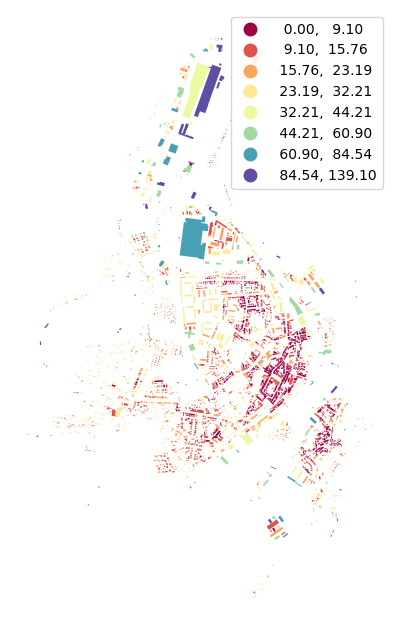

In [5]:
ax = buildings.plot(
    column="neighbour_dist",
    scheme="naturalbreaks",
    k=8,
    legend=True,
    cmap="Spectral",
    figsize=(8, 8),
)
ax.set_axis_off()

## Higher order / distance

However, typical usage of spatial graphs is to capture the vicinity of each feature. As illustrated in the [previous notebook](weights_nb.ipynb), there are multiple options on how to capture it. In this example, we will use queen contiguity of the higher order (3) based on morphological tessellation. Because we want to treat the building itself as part of its neighborhood, we assing self weights on top.

In [6]:
contiguity_k3 = contiguity.higher_order(3).assign_self_weight()
contiguity_k3

<Graph of 3014 nodes and 74814 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

### Neighborhood description

Mean value of selected character within a vicinity of each cell (or building, plot) is a simple example. Most of the common descriptive statistics are available using the method `Graph.describe()`.

In [7]:
describe_k3 = contiguity_k3.describe(tessellation.area)
describe_k3.head()

,count,mean,median,std,min,max,sum,nunique,mode
focal,,,,,,,,,
0,32,6403.946158,5032.069554,4953.470408,56.548307,18236.130095,204926.277050,32,56.548307
1,33,5916.039849,3309.027810,8911.220398,178.883403,47761.123833,195229.315015,33,178.883403
2,42,4745.059093,2592.010950,7801.715031,259.495417,47761.123833,199292.481892,42,259.495417
3,23,6605.411131,5281.292350,6880.998398,494.372518,32552.415503,151924.456008,23,494.372518
4,45,6006.745957,2722.893088,9823.935807,259.495417,62719.163981,270303.568076,45,259.495417


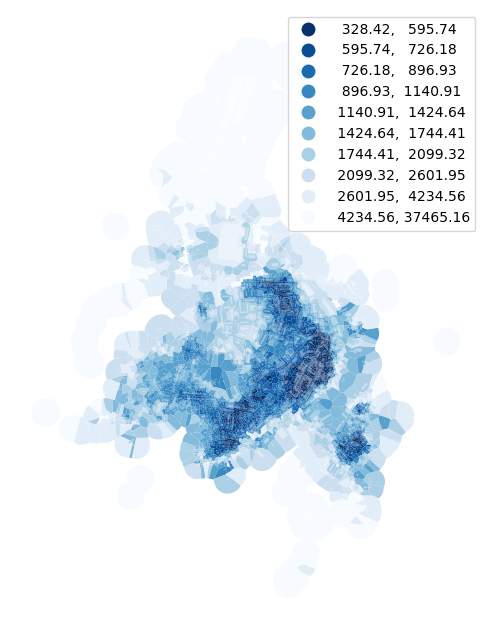

In [8]:
ax = tessellation.plot(
    column=describe_k3["mean"],
    legend=True,
    scheme="quantiles",
    k=10,
    cmap="Blues_r",
    figsize=(8, 8),
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

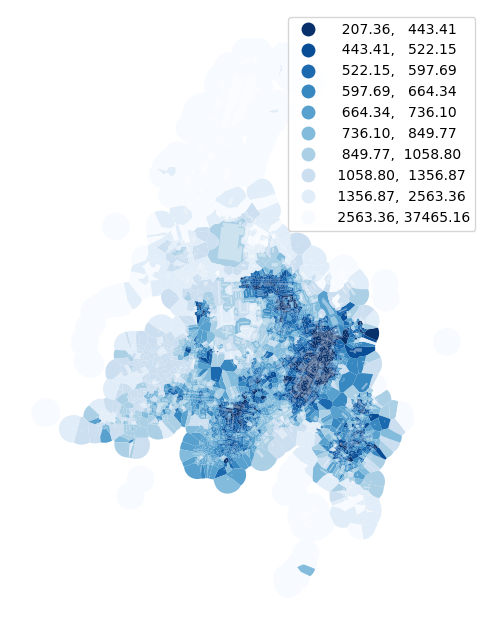

In [9]:
ax = tessellation.plot(
    column=describe_k3["median"],
    legend=True,
    scheme="quantiles",
    k=10,
    cmap="Blues_r",
    figsize=(8, 8),
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

In some cases, we might want to eliminate the effect of outliers. To do so, we can specify the quantile range on which should `describe` work. Below we will measure only interquartile mean.

In [10]:
describe_k3_iqr = contiguity_k3.describe(tessellation.area, q=(25, 75))

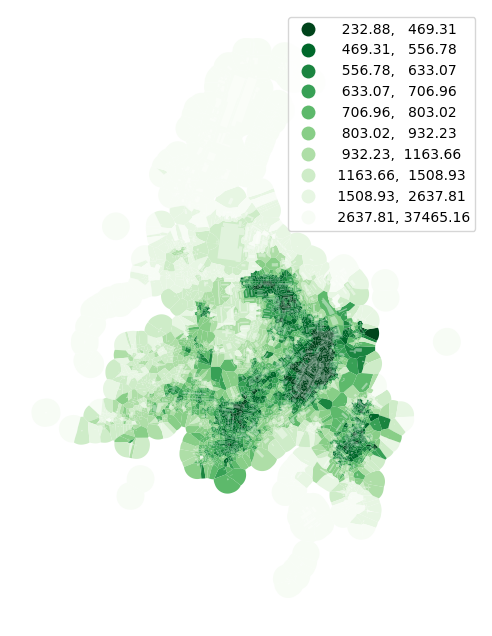

In [11]:
ax = tessellation.plot(
    column=describe_k3_iqr["mean"],
    legend=True,
    scheme="quantiles",
    k=10,
    cmap="Greens_r",
    figsize=(8, 8),
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

### Weighted character

The weighted average is another example using the same spatial graphs. For illustration, we can try area-weighted circular compactness:

In [12]:
circular_compactness = momepy.circular_compactness(buildings)
buildings["weighted_circom"] = momepy.weighted_character(
    circular_compactness, buildings.area, contiguity_k3
)

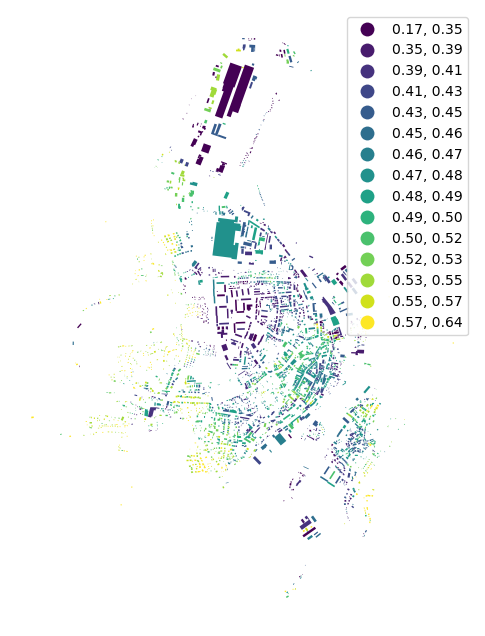

In [13]:
ax = buildings.plot(
    column="weighted_circom",
    legend=True,
    scheme="quantiles",
    k=15,
    cmap="viridis",
    figsize=(8, 8),
)
ax.set_axis_off()

### Density

We will again use our Manhattan case study to illustrate using graphs in capturing gross density.

In [14]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.features_from_point(point, dist=dist, tags={"building": True})
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[
    gdf_projected.geom_type.isin(["Polygon", "MultiPolygon"])
].reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

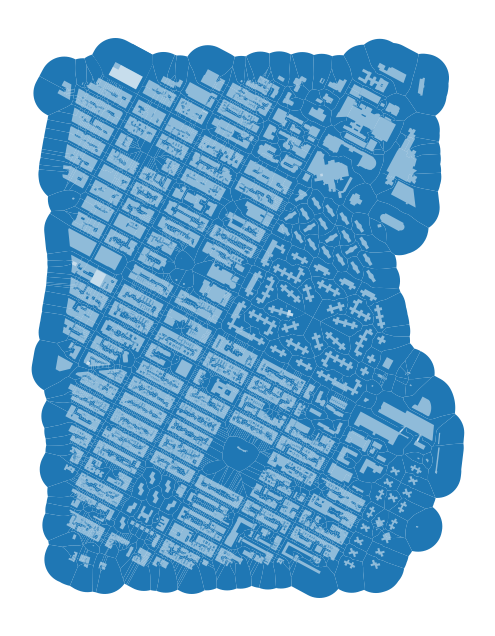

In [15]:
ax = tessellation.plot(figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

To get gross density, we need to know floor areas:

In [16]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)
buildings["floors"] = buildings["height"] // 3

buildings["floor_area"] = buildings.area * buildings["floors"]

Gross density can be expressed as sum of floor area in a neighborhood divided by sum areas within the same neighborhoods. `Graph.describe()` is perfect for that.

First, build the Graph.

In [17]:
contiguity_ny_k3 = (
    graph.Graph.build_contiguity(tessellation)
    .higher_order(3)
    .assign_self_weight()
)
contiguity_ny_k3

<Graph of 3179 nodes and 99847 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

Then you can measure sums and derive gross density.

In [18]:
areas = contiguity_ny_k3.describe(tessellation.area, statistics=["sum"])["sum"]
floor_areas = contiguity_ny_k3.describe(
    buildings["floor_area"], statistics=["sum"]
)["sum"]

tessellation["gross_density"] = floor_areas / areas

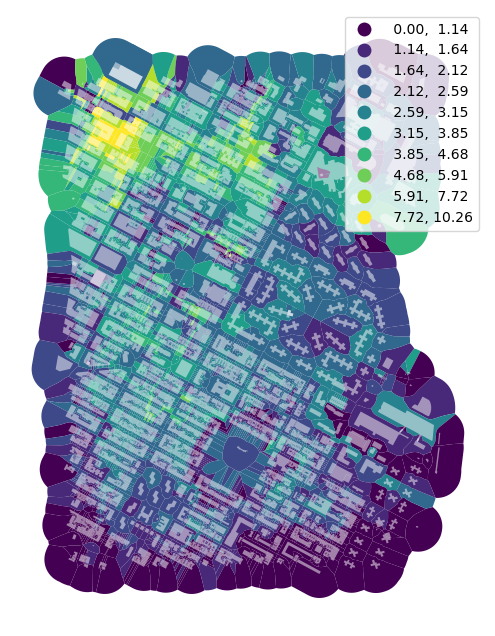

In [19]:
ax = tessellation.plot(
    column="gross_density",
    legend=True,
    scheme="naturalbreaks",
    k=10,
    figsize=(8, 8),
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

In a similar way can be done gross coverage.

In [20]:
areas = contiguity_ny_k3.describe(tessellation.area, statistics=["sum"])["sum"]
blg_areas = contiguity_ny_k3.describe(buildings.area, statistics=["sum"])["sum"]

tessellation["gross_coverage"] = blg_areas / areas

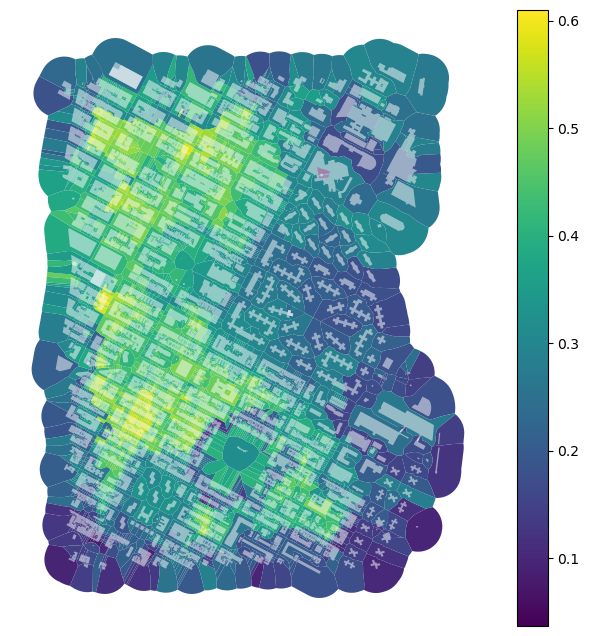

In [21]:
ax = tessellation.plot(figsize=(8, 8), column="gross_coverage", legend=True)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()